In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [11]:
from importlib import reload

import pickle

import numpy as np
import tensorflow as tf
import logging
from scipy import linalg

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plot_func as pf
import util_func as uf

import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,network,connectivity,dynamics_np
from dev_ori_sel_RF.tools import misc,update_params_dict,gen_gaussian_random_field

# Construct heterogeneous recurrent weights

In [22]:
config_name = "big_hetero"
Version = -1
config_dict,N4pop,Nlgnpop,Nret,Nlgn,N4,rA = uf.get_network_size(config_name)
if config_name=="test":
    Nret = 32
    Nlgn = 32
    N4 = 32
    rA = ceil(0.15*N4)
    
W4 = connectivity.Connectivity_2pop((N4,N4),(N4,N4),\
                                    (N4,N4), (N4,N4),\
                                    random_seed=config_dict["random_seed"],\
                                    Nvert=1, verbose=True)
W4to4,arbor4to4 = W4.create_matrix_2pop(config_dict["W4to4_params"],config_dict["W4to4_params"]["Wrec_mode"])

MISC params_dict params_big_hetero {'Nret': 64, 'Nlgn': 64, 'N4': 64, 'N23': 1, 'Nvert': 1, 'runtime': 32000, 'dt': 0.05, 'tau': 1.0, 'num_lgn_paths': 4, 'gamma_lgn': 4.0, 'gamma_4': 1.0, 'gamma_23': 1.0, 'learning_rate_decay_const': 160000.0, 'saving_stepsize': 10, 'plasticity_rule': 'activity_based', 'random_seed': 19, 'nonlinearity_l4': 'rectifier', 'nonlinearity_l23': 'rectifier', 'integrator': 'Euler', 'test_lowDsubset': False, 'developing_params': [], 'Inp_params': {'ndim': 25, 'radius': 3.0, 'width': 1.0, 'simulate_activity': 'dynamics', 'pattern_duration': 2500, 'avg_no_inp': 1, 'expanse_time': 1, 'init_radius': 0.3, 'mean_width': 0.3, 'onoff_corr_factor': 1.0, 'onoff_rel_weight': 1.0, 'input_type': 'white_noise_online', 'off_bias_strength': 0.0, 'off_bias_region_size': 0.5}, 'Wret_to_lgn_params': {'sigma1': 0.01125, 'sigma2': 0.03, 'ampl1': 2.0, 'ampl2': 1.0, 'gamma_ret': 1.0, 'noise': 0.0, 'sigma': 0.016875, 'ampl': 1.0, 'profile': 'Gaussian', 'mean_eccentricity': 0.6, 'SD_ec

(0.9499999999999915+0j)


Text(0.5, 1.0, 'L4 I Cell (Pre)')

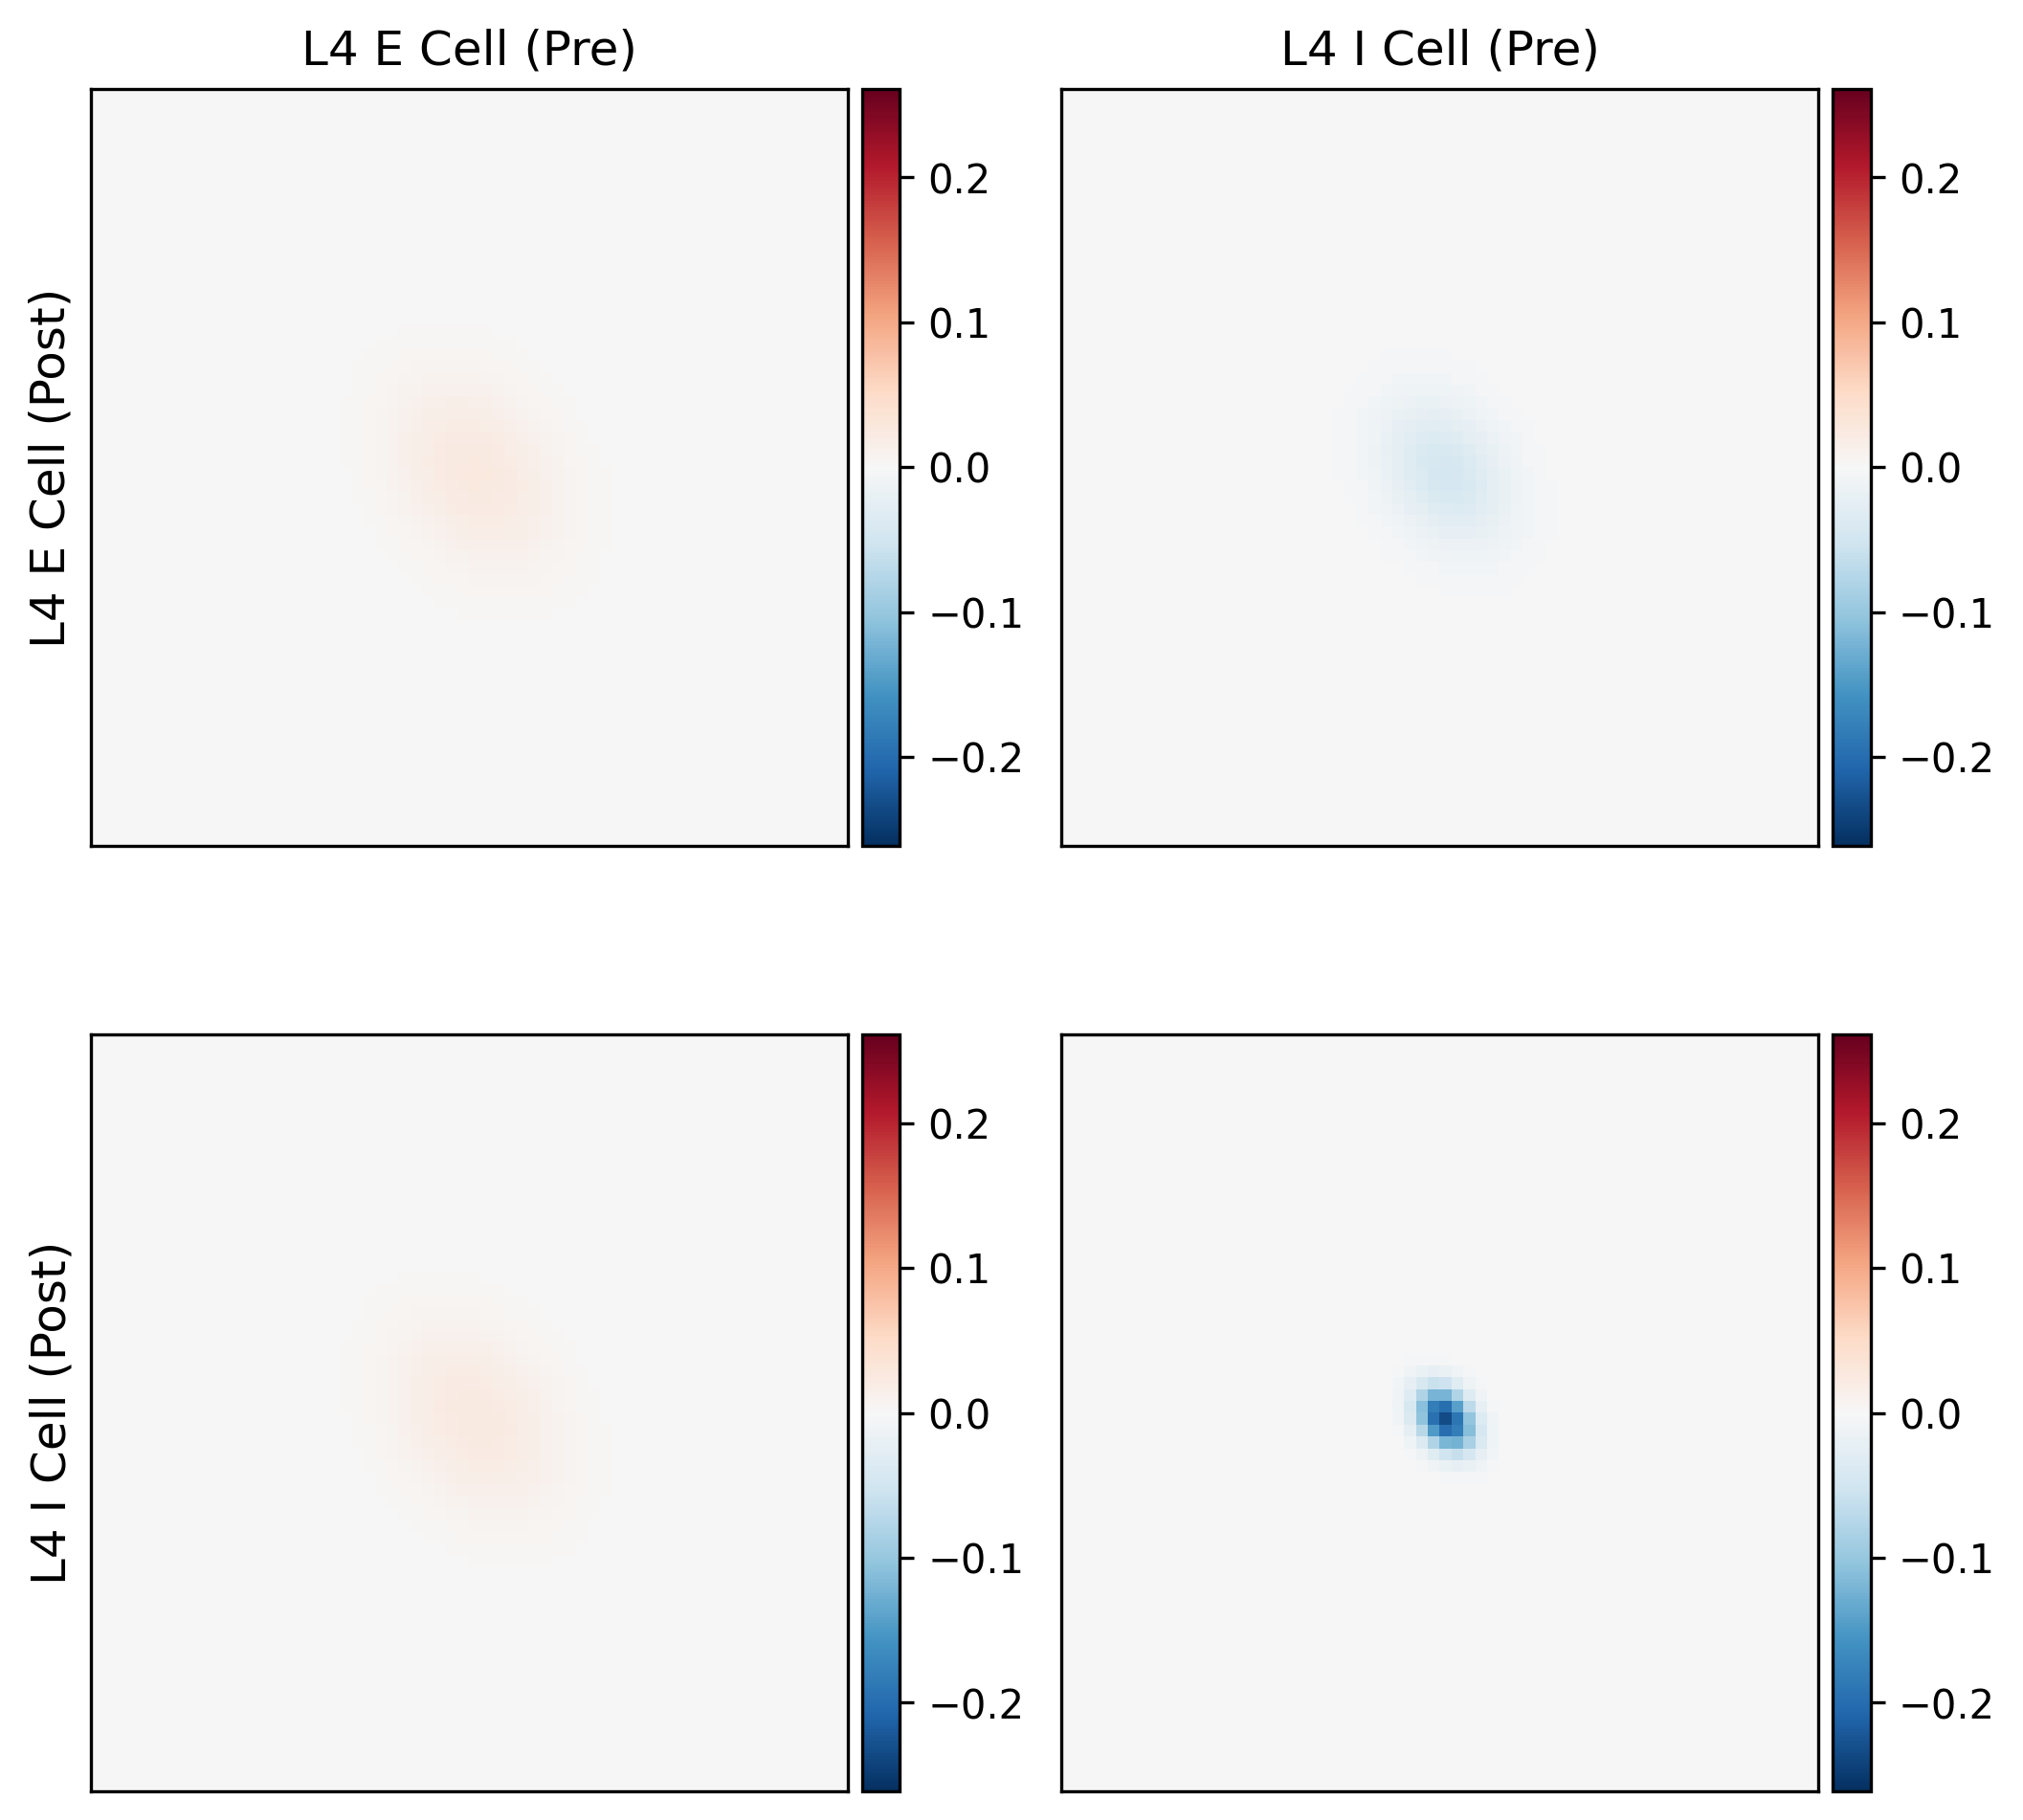

In [23]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

pre_idx = (N4//2,N4//2)
pf.imshowbar(fig,axs[0,0],W4to4[:N4**2,:N4**2].reshape(N4,N4,Nlgn,Nlgn)[:,:,pre_idx[0],pre_idx[1]],
          vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')
pf.imshowbar(fig,axs[0,1],W4to4[:N4**2,N4**2:].reshape(N4,N4,Nlgn,Nlgn)[:,:,pre_idx[0],pre_idx[1]],
          vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,0],W4to4[N4**2:,:N4**2].reshape(N4,N4,Nlgn,Nlgn)[:,:,pre_idx[0],pre_idx[1]],
          vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,1],W4to4[N4**2:,N4**2:].reshape(N4,N4,Nlgn,Nlgn)[:,:,pre_idx[0],pre_idx[1]],
          vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')
print(np.max(np.linalg.eigvals(W4to4)))
axs[0,0].set_ylabel('L4 E Cell (Post)',fontsize=12)
axs[1,0].set_ylabel('L4 I Cell (Post)',fontsize=12)
axs[0,0].set_title('L4 E Cell (Pre)',fontsize=12)
axs[0,1].set_title('L4 I Cell (Pre)',fontsize=12)

# Generate inputs

In [24]:
kap = 2
sig = config_dict['W4to4_params']['sigma_EE']*config_dict['W4to4_params']['sigma_factor']
Lam = np.pi*sig*np.sqrt((kap**2-1)/np.log(kap))
print(Lam)

0.46567469437945164


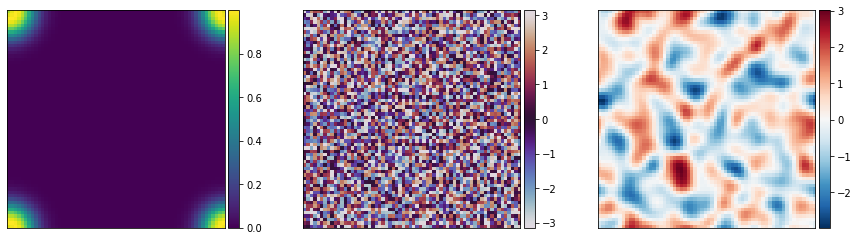

In [66]:
reload(gen_gaussian_random_field)

fig,axs = plt.subplots(1,3,figsize=(15,4))

ring_image = np.fft.fftshift(gen_gaussian_random_field.generate_ring(N4,N4,1/Lam,N4/16))
random_matrix = np.fft.fft2(np.random.randn(N4,N4))
# random_matrix = np.exp(-1j * np.angle(np.fft.fft2(np.random.randn(N4,N4))))
ring_ifft = np.real(np.fft.ifft2(ring_image*random_matrix))
ring_ifft = ring_ifft - np.mean(ring_ifft)
ring_ifft = ring_ifft/np.std(ring_ifft)

pf.imshowbar(fig,axs[0],ring_image,cmap='viridis')
pf.imshowbar(fig,axs[1],np.angle(random_matrix),cmap='twilight')
pf.imshowbar(fig,axs[2],ring_ifft/np.std(ring_ifft),cmap='RdBu_r')

In [29]:
n_inp = 100
inps = np.zeros((n_inp,2,N4,N4))

ring_image = np.fft.fftshift(gen_gaussian_random_field.generate_ring(N4,N4,1/Lam,N4/16))

rng = np.random.default_rng(0)
for inp_idx in range(n_inp):
    for pop_idx in range(2):
        random_matrix = np.fft.fft2(rng.normal(size=(N4,N4)))
        ring_ifft = np.real(np.fft.ifft2(ring_image*random_matrix))
        ring_ifft = ring_ifft - np.mean(ring_ifft)
        ring_ifft = ring_ifft/np.std(ring_ifft)
        inps[inp_idx,pop_idx,:,:] = 1 + 1e-3*ring_ifft

In [37]:
inps[0].reshape((-1))

array([0.99893536, 0.99919115, 0.99952186, ..., 1.00019718, 0.99988635,
       0.99961296])

# Simulate dynamics to get activation patterns

In [61]:
def fio_rect(x):
    x[x<0] = 0
    return x

def dynamics_system(y,inp_ff,Wrec,\
                    gamma_rec,gamma_ff,N,tau):
    argE = gamma_rec * np.dot(Wrec[:N],y) + gamma_ff * inp_ff[0]
    argI = gamma_rec * np.dot(Wrec[N:],y) + gamma_ff * inp_ff[1]
    return 1./tau*( -y + fio_rect(np.concatenate([argE,argI])))

def integrate(y0,inp,dt,Nt):
    y = y0
    for t_idx in range(Nt):
        out = dynamics_system(y,inp,W4to4,\
                             1.02,1.0,N4*N4,1.0)
    dy = out
    y = y + dt*dy
    return np.array([y[:N4**2].reshape((N4,N4)),y[N4**2:].reshape((N4,N4))])

In [62]:
rates = np.zeros_like(inps)
for inp_idx in range(n_inp):
    rates[inp_idx] = integrate(np.ones(2*N4**2),inps[inp_idx].reshape((2,-1)),0.05,50)

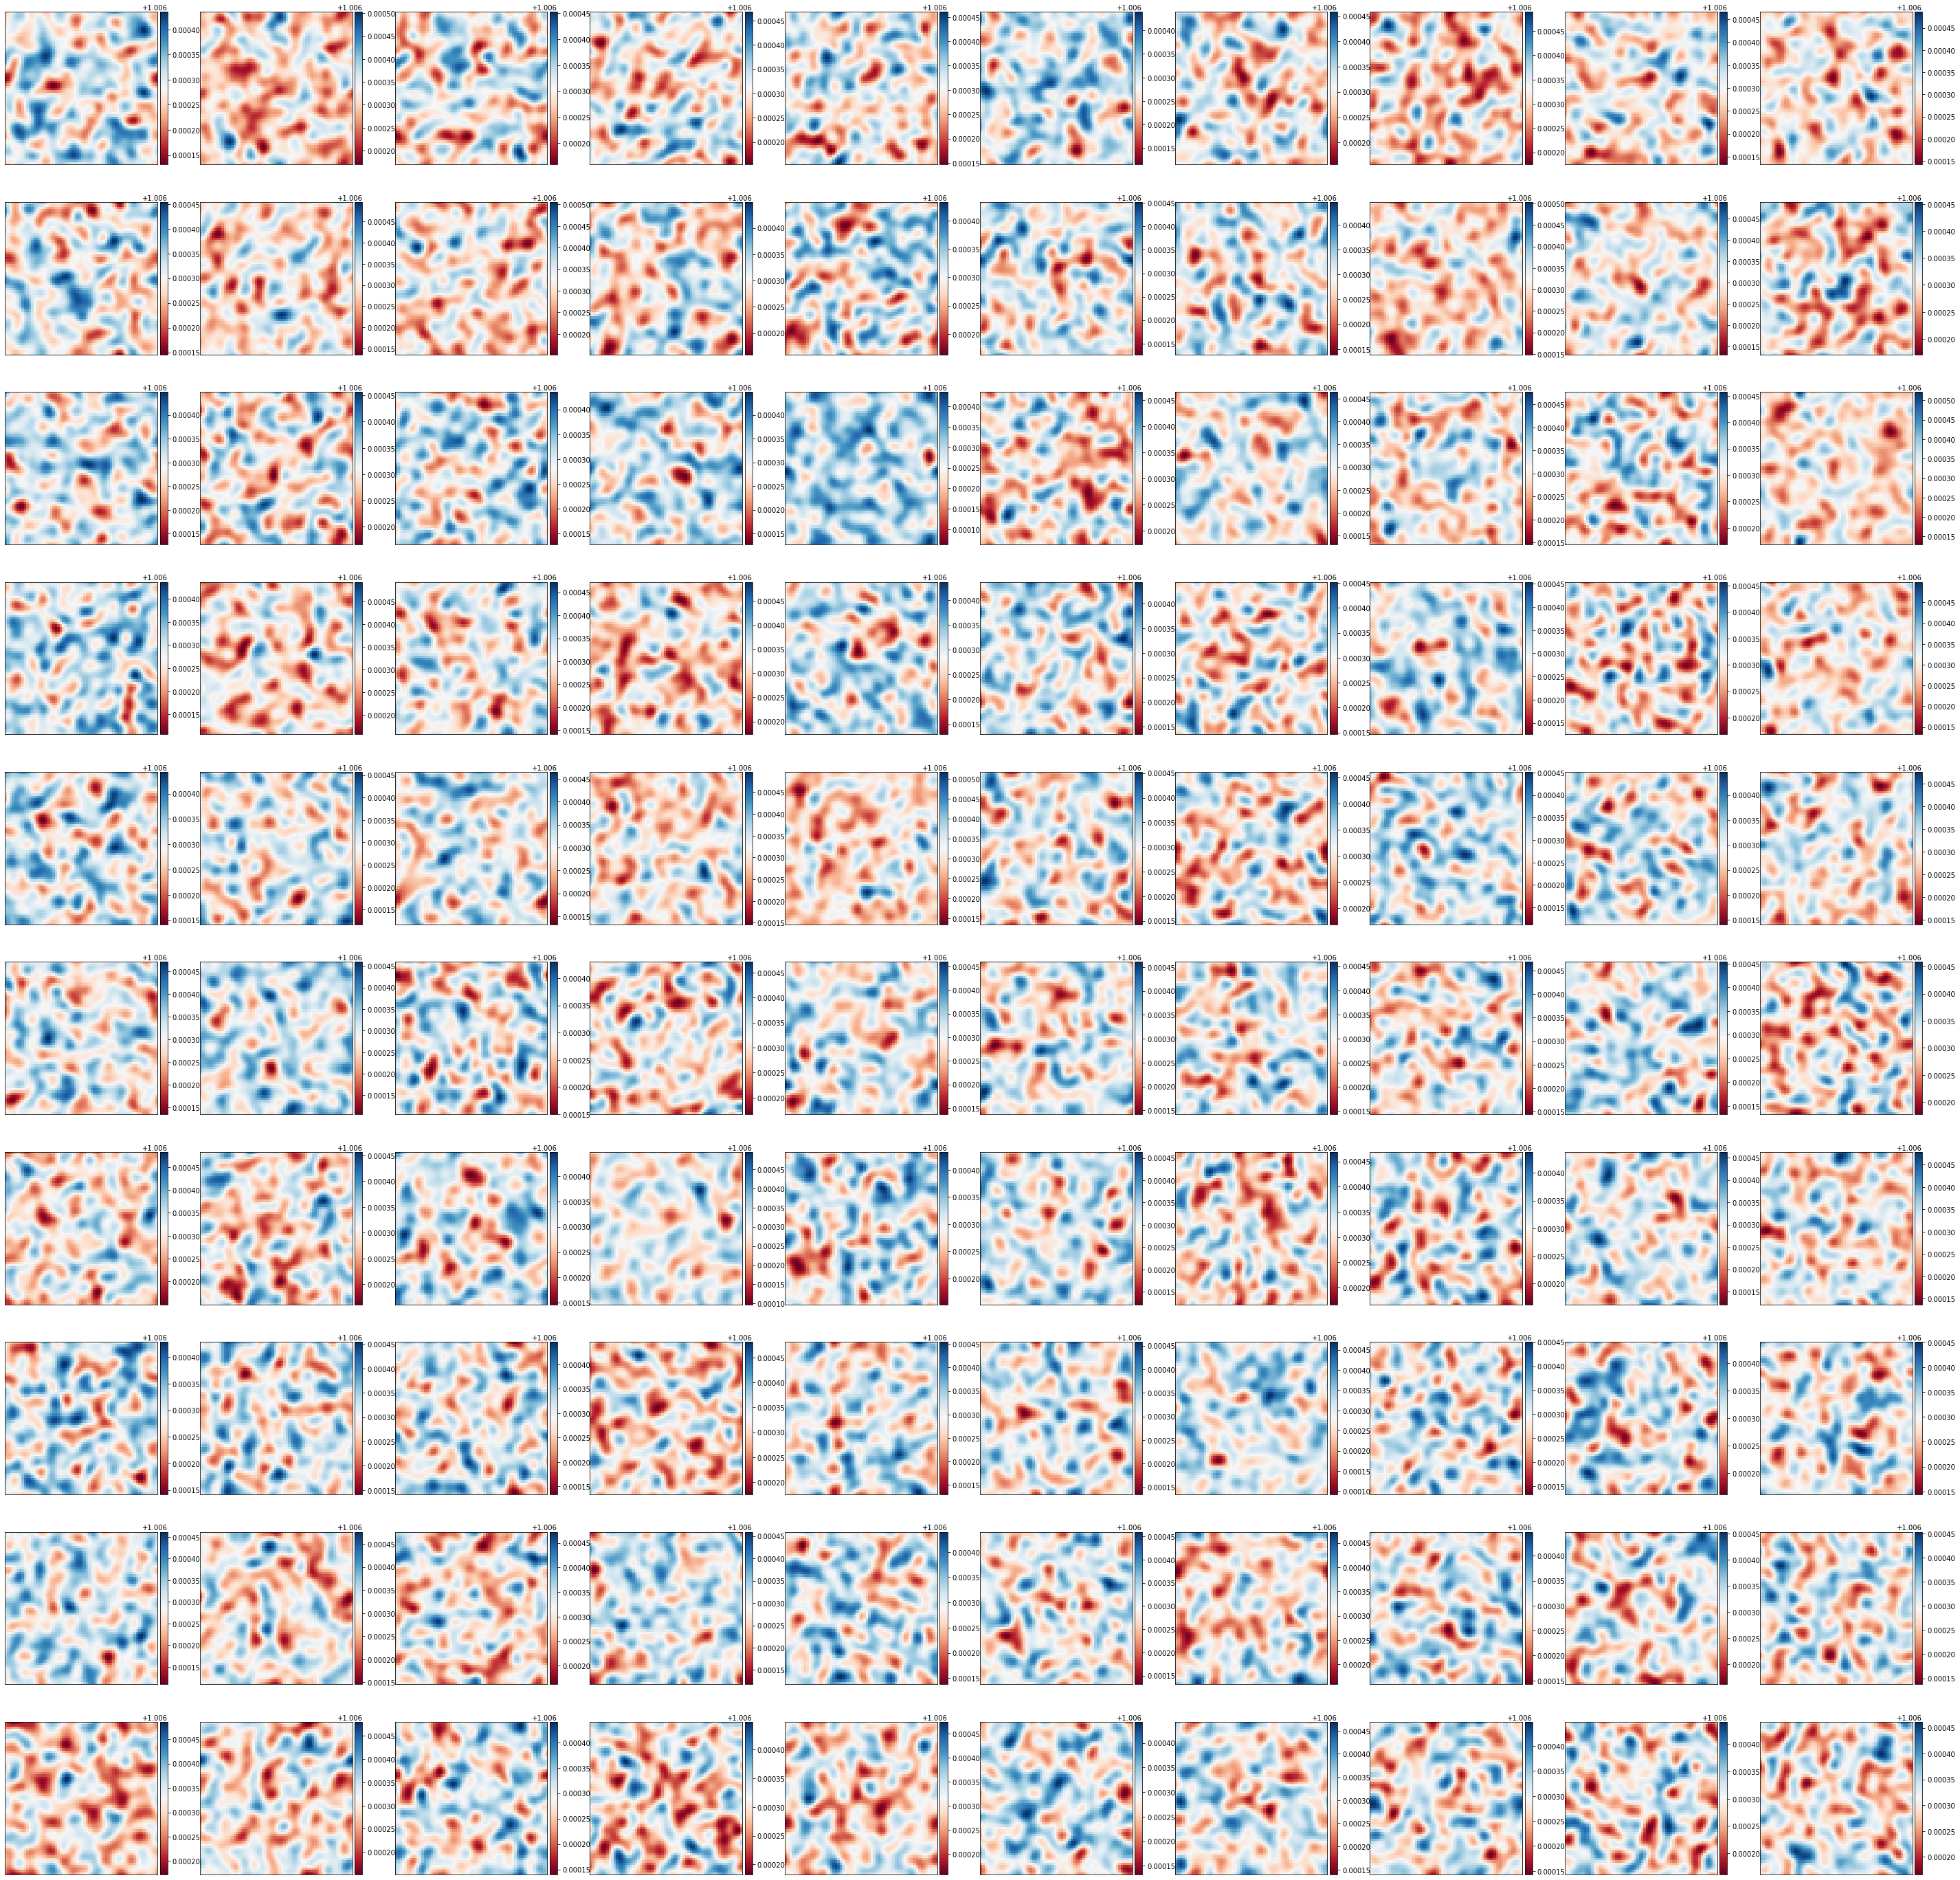

In [64]:
fig,axs = plt.subplots(10,10,figsize=(50,50))

for i in range(10):
    for j in range(10):
        idx = i*10+j
        pf.imshowbar(fig,axs[i,j],rates[idx,0])

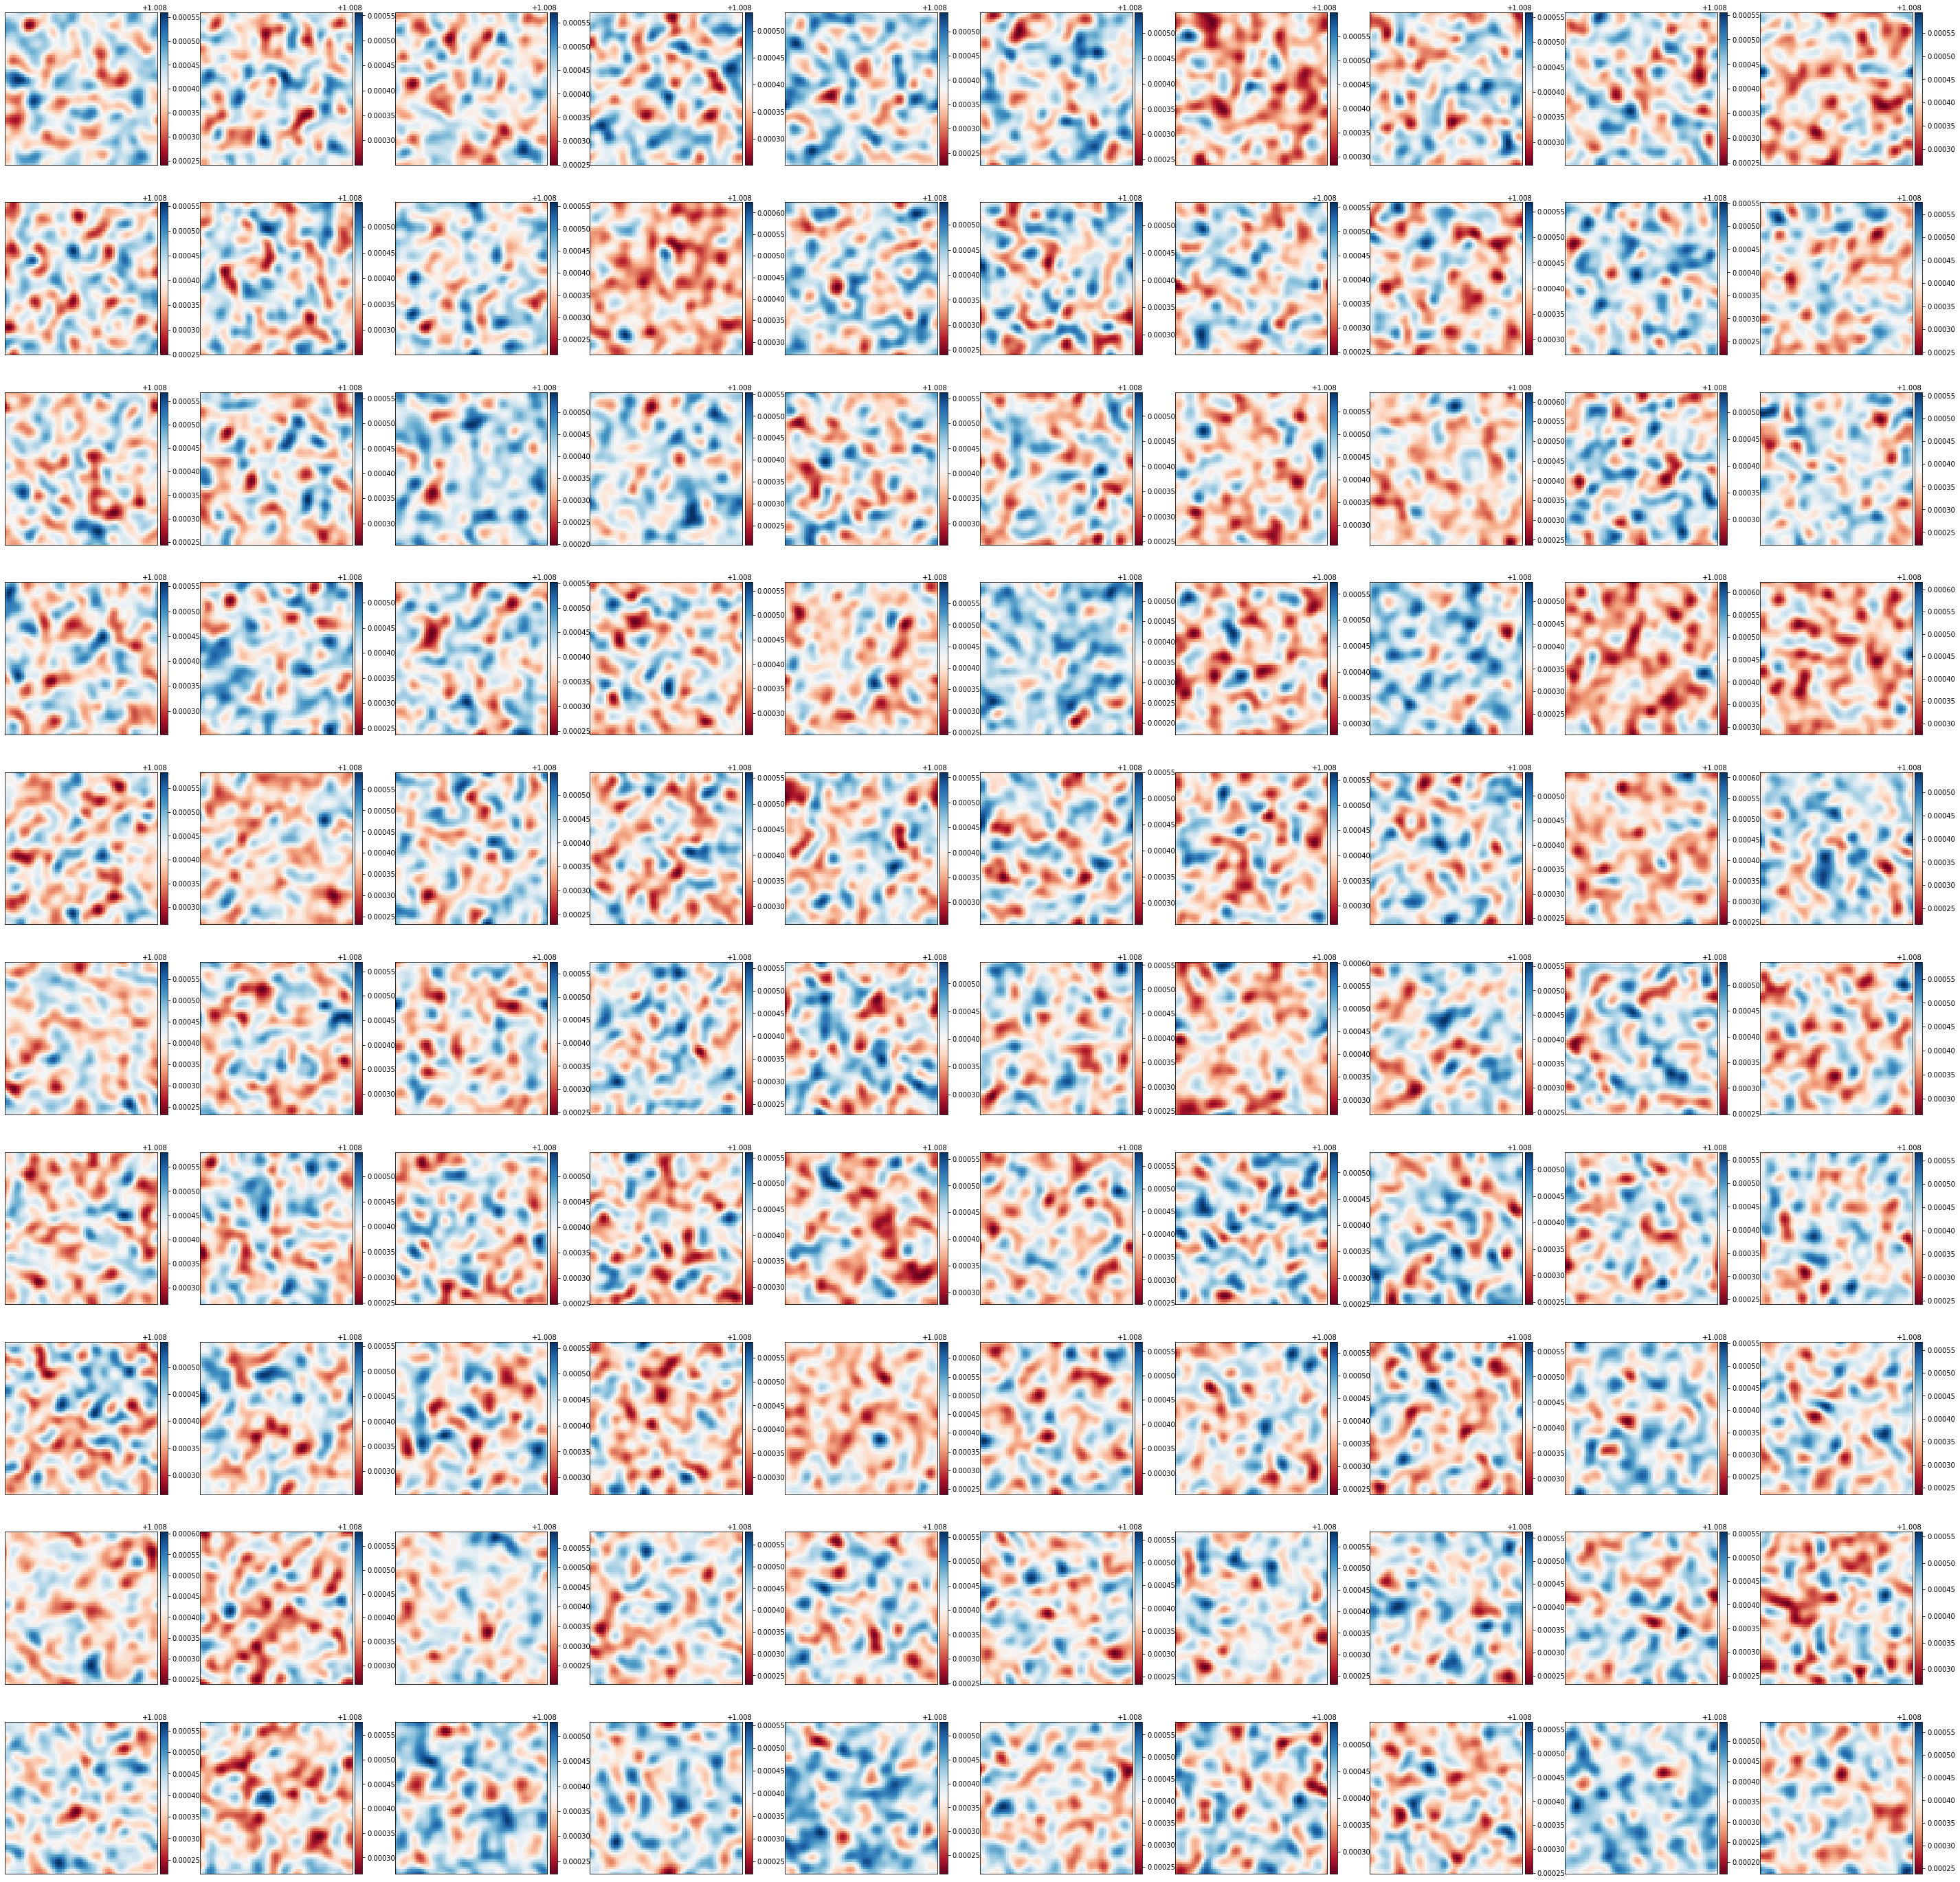

In [67]:
fig,axs = plt.subplots(10,10,figsize=(50,50))

for i in range(10):
    for j in range(10):
        idx = i*10+j
        pf.imshowbar(fig,axs[i,j],rates[idx,1])

# Calculate correlation patterns

In [ ]:
seed_pt = (N4//2,N4//2)